In [1]:
git_repo = '../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib
import LinearResponseVariationalBayes.ModelSensitivity as sens_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

In [2]:
import checkpoints
checkpoints.__file__

'/usr/local/lib/python3.5/dist-packages/checkpoints/__init__.py'

In [3]:
# Load results from previous fit.
filename = 'ryan_iris_bnp_full_data_fit_alpha8.0.json'
#filename = 'ryan_simulation_bnp_full_data_fit_alpha1.0.json'
#filename = 'ryan_simulation_bnp_full_data_fit_alpha1.0.json'
json_input_file = os.path.join(
    git_repo,
    'BNP_sensitivity/GMM_clustering/iris_fits/',
    filename)

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [4]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [5]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[ 0.38666612 -0.83707578  0.26621971 -0.76655108  0.16580191  0.14542863
   0.12573002  0.10581364  0.0854393   0.06483547  0.04464156  0.56483837]
 [-0.23790379  0.36417584 -0.36832691 -0.47140487 -0.24397179 -0.2386567
  -0.2358718  -0.23474327 -0.23489075 -0.23605722 -0.23796877 -0.0348946 ]
 [ 0.93725828 -2.29444968  1.50922881  0.70397795  1.00485126  0.95974494
   0.92240272  0.88913282  0.85849963  0.83006033  0.80391681  1.63376004]
 [ 0.28262994 -0.95459406  0.37664286  0.43212211  0.37784028  0.36344441
   0.3502652   0.33775649  0.32573857  0.31424943  0.30346891  0.92716892]]
	cluster_weights:
[0.41680693 0.31731646 0.01236364 0.01148978 0.00924401 0.00877311
 0.00835093 0.00796464 0.0076076  0.0072757  0.0069661  0.1858411 ]
	v_sticks:
[-0.33804775  0.17876426 -3.25503707 -3.29425403 -3.5280073  -3.55056991
 -3.56974917 -3.58676344 -3.60214176 -3.61613863 -3.62888088]


In [6]:
print(model.prior_params)

prior_params:
	alpha: [8.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [7]:
# Define a perturbation in the logit v space.

phi_center = -2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))

0.6931471805599453


This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [8]:
prior_perturbation = fun_sens_lib.PriorPerturbation(model, log_phi)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

3.4618220034785896 -3.6937667578411086 -2.2246409632880852 -1.0222582344004703


phi max:  0.49997474875006853


Text(0.5,1,'Priors in logit space')

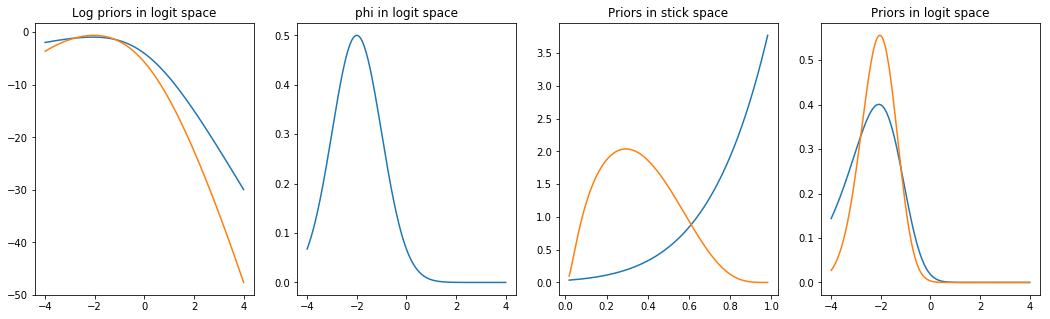

In [9]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = np.linspace(-4, 4, 200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [10]:
# Choose the number of GH points.
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

prior_perturbation.set_epsilon(1.0)

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(
        prior_perturbation.model.vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        prior_perturbation.get_e_log_perturbation(sum_vector=False))

print(expected_perturbations_list[0])
expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1)
print(max_diffs)
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_threshold)
print(gh_deg, gh_deg_threshold, len(max_diffs))

[2.08720797 3.08838927 1.74574207 1.80912471 2.19652354 2.24073044
 2.27924813 2.31409619 2.34613173 2.37574582 2.40311219]
[3.69594917e-16 2.02178124e-16 6.06534372e-16 9.74200680e-16
 3.89680272e-16 2.87586200e-16 3.83812064e-16 5.75718096e-16
 3.96378791e-16 4.90943451e-16 2.45471725e-16 4.31379300e-16
 3.96378791e-16 3.89680272e-16 3.89680272e-16 2.45471725e-16
 3.69594917e-16 4.04356248e-16 6.06534372e-16 5.84520408e-16
 3.89680272e-16 3.73852303e-16 3.89680272e-16 4.31379300e-16
 3.83812064e-16 5.75718096e-16 2.12767009e-16 5.08768121e-16
 2.54384060e-16 2.87586200e-16 1.86926152e-16 3.96378791e-16
 3.78571259e-16 3.78571259e-16 3.83812064e-16 4.25534018e-16
 2.54384060e-16 2.12767009e-16 2.12767009e-16 3.73852303e-16
 3.89680272e-16 2.02178124e-16 4.31379300e-16 2.54384060e-16
 3.81576091e-16 3.96378791e-16 4.31379300e-16 2.02178124e-16
 3.96378791e-16 4.04356248e-16 2.02178124e-16 3.96378791e-16
 2.87586200e-16 3.96378791e-16 2.02178124e-16 2.12767009e-16
 3.69594917e-16 5.5439

In [11]:
# First fit with no perturbation but the increased number of gh points.

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 11.252659818984101	 Objective: -305.35833030090714
Iter: 1	 RMSE: 11.252659791489648	 Objective: -305.3583303009109
Optimization terminated successfully.
         Current function value: -305.358330
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter: 2	 RMSE: 11.252659791489647	 Objective: -305.35833030091004
Iter: 3	 RMSE: 11.252659791498788	 Objective: -305.35833030091015
         Current function value: -305.358330
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. 


In [12]:
# This expects the hyperparameter to be at its optimal value.
prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=prior_perturbation.model.global_vb_params,
        output_par=moment_model.moment_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=moment_model.set_moments,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)
    

In [13]:
prior_perturbation.get_e_log_perturbation()
np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper())

14.025327992773335

## Fit with perturbation

In [14]:
epsilon = 1.0
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
    epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  1.0
Predicted differences:  14.025327992773335


In [15]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)
best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)

output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

epsilon: 1.0
Iter  0  value:  -188.63523625348486
Iter  1  value:  -207.47847864331524
Iter  2  value:  -204.25714137352975
Iter  3  value:  -216.74283558613476
Iter  4  value:  -230.67657273566994
Iter  5  value:  -238.1730059030385
Iter  6  value:  -229.07837749465645
Iter  7  value:  -244.98476123987345
Iter  8  value:  -250.22687350518572
Iter  9  value:  -257.42871470120804
Iter  10  value:  -264.4658134567257
Iter  11  value:  -268.24262306791525
Iter  12  value:  -276.8375576313614
Iter  13  value:  -229.36731543307158
Iter  14  value:  -272.2911754885233
Iter  15  value:  -280.1554832718453
Iter  16  value:  -282.25284151929054
Iter  17  value:  -283.627258207013
Iter  18  value:  -285.51701658756787
Iter  19  value:  -287.02723321692514
Iter  20  value:  -288.3249904534298
Iter  21  value:  -289.5793551585741
Iter  22  value:  -290.3417230385077
Iter  23  value:  -291.88295241470763
Iter  24  value:  -293.0861111416293
Iter  25  value:  -293.1511330079705
Iter  26  value:  -29

Epsilon: 1.0


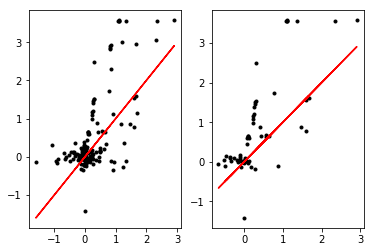

In [16]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

plt.subplot(1, 2, 2)
plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [30]:
taylor_expansion = \
    sens_lib.ParametricSensitivityTaylorExpansion(
        objective_functor=model.set_z_get_kl,
        input_par=prior_perturbation.model.global_vb_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_val0=best_param_0,
        hyper_val0=0.0,
        order=4,
        input_is_free=True,
        hyper_is_free=False,
        hyper_par_objective_functor=prior_perturbation.get_e_log_perturbation,
        hess0=kl_hessian_0)


Epsilon: 1.0


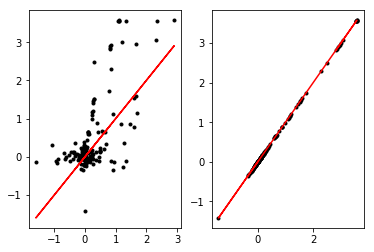

In [31]:
taylor_phi_pred = taylor_expansion.evaluate_dkinput_dhyperk(
    dhyper=epsilon - 0, k=1)

print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, taylor_phi_pred, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

plt.subplot(1, 2, 2)
best_param_phi_pred
plt.plot(best_param_phi_pred - best_param_0, taylor_phi_pred, 'k.')
plt.plot(best_param_phi_pred - best_param_0, best_param_phi_pred - best_param_0, 'r')


In [35]:
taylor_phi_pred = taylor_expansion.evaluate_taylor_series(
    dhyper=epsilon - 0, max_order=4)

/home/rgiordan/Documents/git_repos/autograd/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epsilon: 1.0


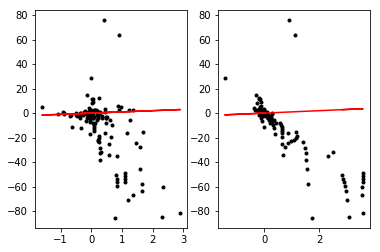

In [36]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, -(taylor_phi_pred - best_param_0), 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

plt.subplot(1, 2, 2)
best_param_phi_pred
plt.plot(best_param_phi_pred - best_param_0, -(taylor_phi_pred - best_param_0), 'k.')
plt.plot(best_param_phi_pred - best_param_0, best_param_phi_pred - best_param_0, 'r')
